In [1]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
# -*- coding: UTF-8 -*-
from __future__ import division
import numpy as np
import pandas as pd
import sys
import math
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import re
import os
import csv
from helpers.outliers import MyOutliers
from skroutz_mobile import SkroutzMobile
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from skroutz_mobile import SkroutzMobile
from sklearn.model_selection import StratifiedShuffleSplit
from helpers.my_train_test_split import MySplitTrainTest
from sklearn.preprocessing import StandardScaler
from preprocess_price_history import PreprocessPriceHistory
from price_history import PriceHistory
%matplotlib inline

In [3]:
random_state = np.random.RandomState(seed=16011984)

In [4]:
csv_in = "../price_history_00.csv"
csv_out = "../price_history_01_no_spikes.csv"

In [5]:
orig_df = pd.read_csv(csv_in, index_col=0, encoding='utf-8', quoting=csv.QUOTE_ALL)

In [6]:
df = orig_df.drop(labels=PriceHistory.SPECIAL_COLS, axis=1)

In [7]:
bounds = PreprocessPriceHistory.getBounds(df=df.T, kk=15, outlier_columns=df.T.columns)
price_histories_big_outliers = PreprocessPriceHistory.countOutliers(df=df.T, bounds=bounds)
print len(price_histories_big_outliers)
price_histories_big_outliers

/home/student/anaconda2/envs/dis/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/student/anaconda2/envs/dis/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


17


8874019     1
11860092    1
9633962     1
10909904    4
8012281     4
10922599    3
9333571     9
10468270    1
10001441    2
10019997    1
9473245     1
10646927    1
9332994     6
7945834     4
11775269    1
11435749    1
8130418     3
dtype: object

Note that we are passing the dataframe reversed

#### Let's plot all of these price 17 price histories to see what is going on

In [8]:
axis_indifferent = np.arange(len(df.columns))
axis_indifferent[:4]

array([0, 1, 2, 3])

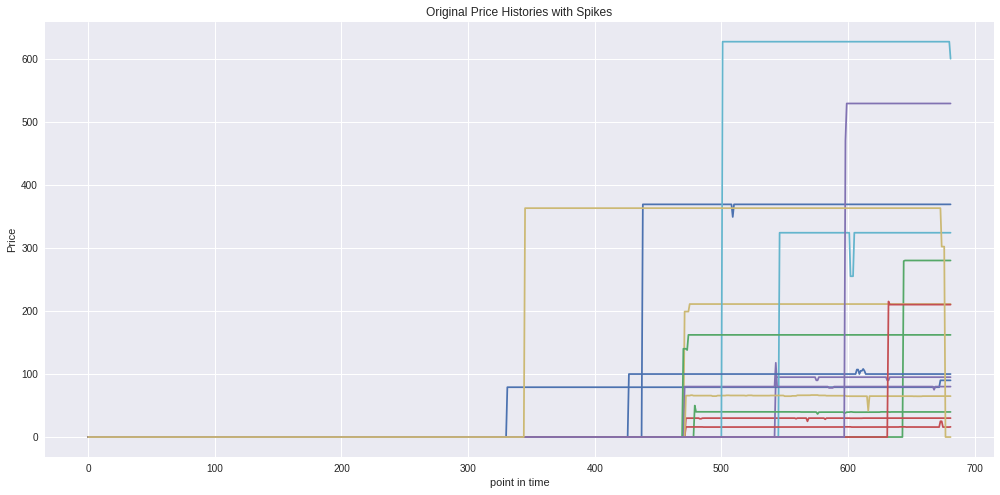

In [11]:
plt.figure(figsize=(17,8))
for ind, history in df.loc[price_histories_big_outliers.index].iterrows():
    #nums = [float(str) for str in history.values]
    #print history.values
    plt.plot(axis_indifferent, history.values)
plt.title('Original Price Histories with Spikes')
plt.xlabel('point in time')
plt.ylabel('Price')
plt.show()

#### Conclusion
We notice that we have indeed some strange spikes for cellphones with two characteristics:
 - Their price does not change a lot, they have constant trend
 - The outliers are seen only once causing these spikes in the plot

One idea is to remove these spikes by taking the average of the two nearest points, only would would suffice they way we observe the data.

This is because we would not expect our prediction system to be able to predict these spikes which indicate something abnormal and very temporary has occured. On the customer side most customers would not be able to react that fast.

In [12]:
inds = MyOutliers.getOutliersIndices(data = df.T, bounds=bounds,
                                     filtering = lambda arr: arr > 0)

In [13]:
outliers_per_sku = inds.loc[price_histories_big_outliers.index]
outliers_per_sku

8874019                                              [71]
11860092                                              [0]
9633962                                              [96]
10909904                                 [32, 33, 88, 89]
8012281                                      [0, 1, 2, 3]
10922599                                     [56, 57, 58]
9333571     [342, 343, 344, 345, 346, 347, 348, 349, 350]
10468270                                              [0]
10001441                                       [201, 202]
10019997                                             [72]
9473245                                             [144]
10646927                                            [180]
9332994                    [180, 181, 183, 184, 185, 186]
7945834                                      [0, 1, 2, 3]
11775269                                              [0]
11435749                                              [0]
8130418                                   [329, 330, 331]
dtype: object

In [14]:
df_no_spikes = PreprocessPriceHistory.removeSpikes(df=df, outliers_per_sku=outliers_per_sku)

In [15]:
bounds = PreprocessPriceHistory.getBounds(df=df_no_spikes.T, kk=15,
                                          outlier_columns=df_no_spikes.T.columns)
print PreprocessPriceHistory.countOutliers(df=df_no_spikes.T, bounds=bounds)

9633962     1
10019997    1
dtype: object


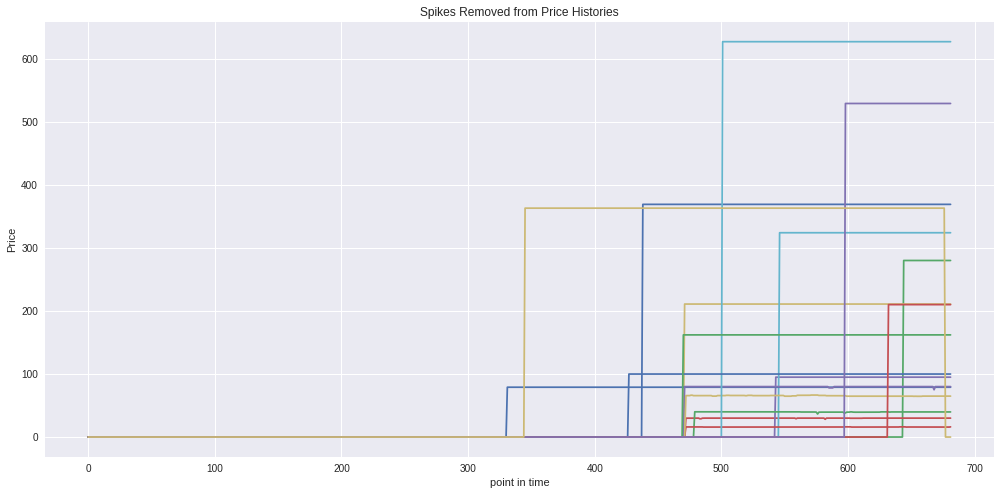

In [16]:
plt.figure(figsize=(17,8))
for ind, history in df_no_spikes.loc[price_histories_big_outliers.index].iterrows():
    plt.plot(axis_indifferent, history.values)
plt.title('Spikes Removed from Price Histories')
plt.xlabel('point in time')
plt.ylabel('Price')
plt.show()

#### Conclusion
We have seen that by removing spikes the cellphones with steady price remain steady without experiencing any extreme changes which could have come from various sources

In [17]:
final_df = pd.concat( (df_no_spikes, orig_df[PriceHistory.SPECIAL_COLS]), axis=1 )
df_no_spikes.shape, final_df.shape

((837, 682), (837, 683))

In [18]:
#final_df.to_csv(csv_out, encoding='utf-8', quoting=csv.QUOTE_ALL)